# 1.3 Computing the biased CVs

### Imports

In [ ]:
## import required packages
import os, math, sys
import numpy as np
import matplotlib.pyplot as plt
import simtk.openmm.app  as omm_app
import simtk.openmm as omm
import simtk.unit as unit
from tqdm import tqdm
import mdtraj
from FastMBAR import *
from tqdm.notebook import tqdm_notebook

### Aims of this Notebook

The aim of this notebook is to show how to easily fetch your RC from your resulting trajectories. We will be using mdtraj for this. 

You will learn: 
1. Calculate interatomic distances on mdtraj for your trajectories
2. Visualize the distances from the trajectories
3. Assess the overlapping of the different windows. 
4. Plot a simple histogram of the sampled biased data. 

## Introduction

After running the umbrella sampling on the NaCl complex we will have to calculate their distance at each of the windows/trajectories generated in order to reconstruct the free energy profile of the dissociation in water. In our case the reaction coordinate (RC) of the process is the interatomic distance between Na and Cl. For this we will use the mdtraj module which quickly loads the trajectory and calculates the distances for the atoms we specify.

<center>
<img src="images/dissociation.png" alt="NaCl" width="500"/>
</center>

-------

## Hands-on Code

### Loading trajectory and calculating distances

In order for mdtraj to calculate the distances we need to specify the topology for the .dcd file we saved. Additionally we will have to provide the atom index for the atoms we want to calculate the distance of. In our case 0 and 1 (python indexing based) are the relevant atoms. Then we will save the data in a .csv file for later analysis with the unbiasing tools to recover the profiles. 

In [ ]:
#We need to load the topology so mdtraj knows what is what
topology = mdtraj.load_psf('toppar/step3_input.psf')

#Depending on the number of umbrellas we used we will have the same trajectories
M = 15

all_dists = []
for window in range(M):
    #traj = mdtraj.load_dcd(f"trajectories/traj_{window+1}_US_test.dcd", topology)
    traj = mdtraj.load_dcd(f"trajectories/long_traj/traj_win{window+1}_US.dcd", topology) #WARNING! Uncomment in case you could not run the umbrellas
    dist = mdtraj.compute_distances(traj, [[0, 1]]) #Calculate distance
    np.savetxt(f"output_files/dist_win_{window+1}.csv", dist, fmt = "%.5f", delimiter = ",") # Save them for later analysis
    all_dists.append(dist.T[0]) #Append to the list 
    
all_dists = np.array(all_dists)*10 #We multiply by 10 so it's in Angstroms when we plot them

After calculating the distances, we'll make a few checks to see if the sampled datapoints are correct and if they sample the space.

Text(0.5, 0, 'Steps')

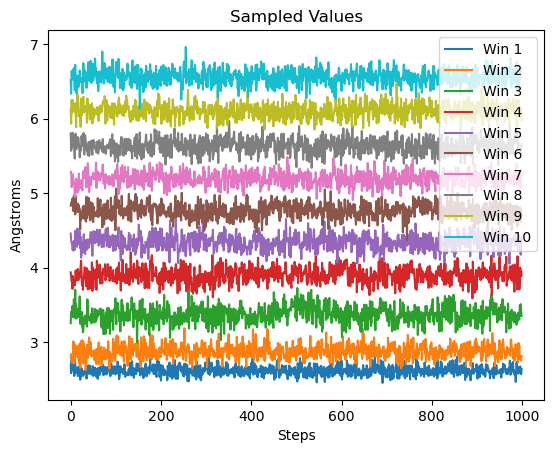

In [ ]:
plt.title("Sampled Values")
for window in range(M):
    plt.plot(all_dists[window], label=f"Win {window+1}")
plt.legend()
plt.ylabel("Angstroms")
plt.xlabel("Steps")

As seen previously the windows sample throughout the RC space, from 2Å up to 7Å the endpoint of our umbrella centers. We see some overlapping, but we want to see how well the windows overlap, otherwise the space in between could not be sampled properly. 

Text(0.5, 0, 'Distance in Angstroms')

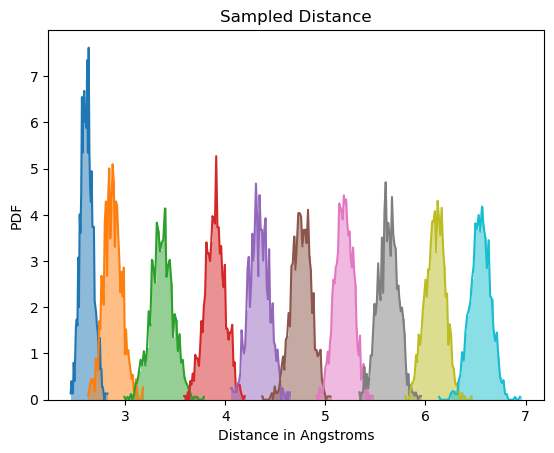

In [ ]:
plt.title("Sampled Distance")
for n, dist in enumerate(all_dists):
    counts, bins, _ = plt.hist(dist, bins=50, density=True, alpha=0.5, color=f"C{n}")
    plt.plot(bins[:-1], counts, c=f"C{n}")
plt.ylabel("PDF")
plt.xlabel("Distance in Angstroms")

You can nicely see how each umbrella window has sampled a region of the RC and you see more centers have been placed between 2Å and 4Å, which is the region where the energy barrier of the dissociation can be found. We can plot the resulting sampled histogram for all trajectories to see how its profile looks like

Text(0.5, 0, 'Distance in Angstroms')

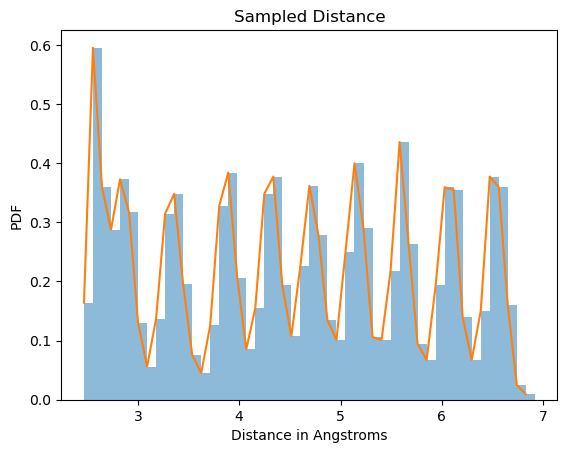

In [ ]:
plt.title("Sampled Distance")
counts, bins, _ = plt.hist(np.concatenate(all_dists), bins=50, density=True, alpha=0.5)
plt.plot(bins[:-1], counts)
plt.ylabel("PDF")
plt.xlabel("Distance in Angstroms")

If the data were to be unbiased, we could have tried to simply construct the profile from the resulting histogram. As you see, the profile resembles the one of a dissociation, we did sample throughout the RC, but even the umbrellas can be seen from here. 

-----

## Optional tasks

We recommend if time allows, or at home, to try the following:
- Try generating the histograms with less data using all_dists[start:end] i.e. all_dists[0:500] or striding the data all_dists[::10]. 